In [10]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [11]:
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data.sampler import SubsetRandomSampler

num_workers = 0
batch_size = 20
valid_size = 0.2

# transform the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# choose the training and testing set
train_data = datasets.CIFAR10('data', train=True, download=True, 
                              transform=transform )

test_data = datasets.CIFAR10('data', train=False, download=True, 
                              transform=transform )

# split to train and test
dataset_size = len(train_data)
indices = list(range(dataset_size))
np.random.shuffle(indices)
split = int(np.floor(valid_size * dataset_size))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# set the loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

<ipython-input-17-915dadd57362>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])


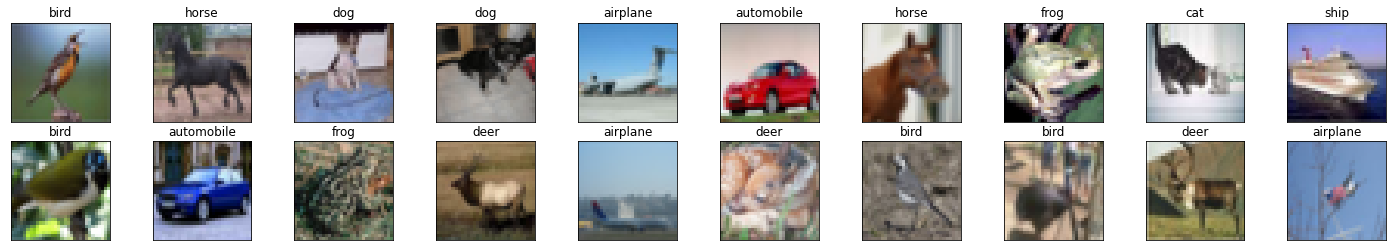

In [17]:
# obtain a single batch of training example
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert the images to numpy array to display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for i in np.arange(20):
    ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    imshow(images[i])
    ax.set_title(classes[labels[i]])

In [20]:
print(images[3].shape)

(3, 32, 32)


In [19]:
rgb_img = np.squeeze(images[3])
print(rgb_img.shape)

(3, 32, 32)


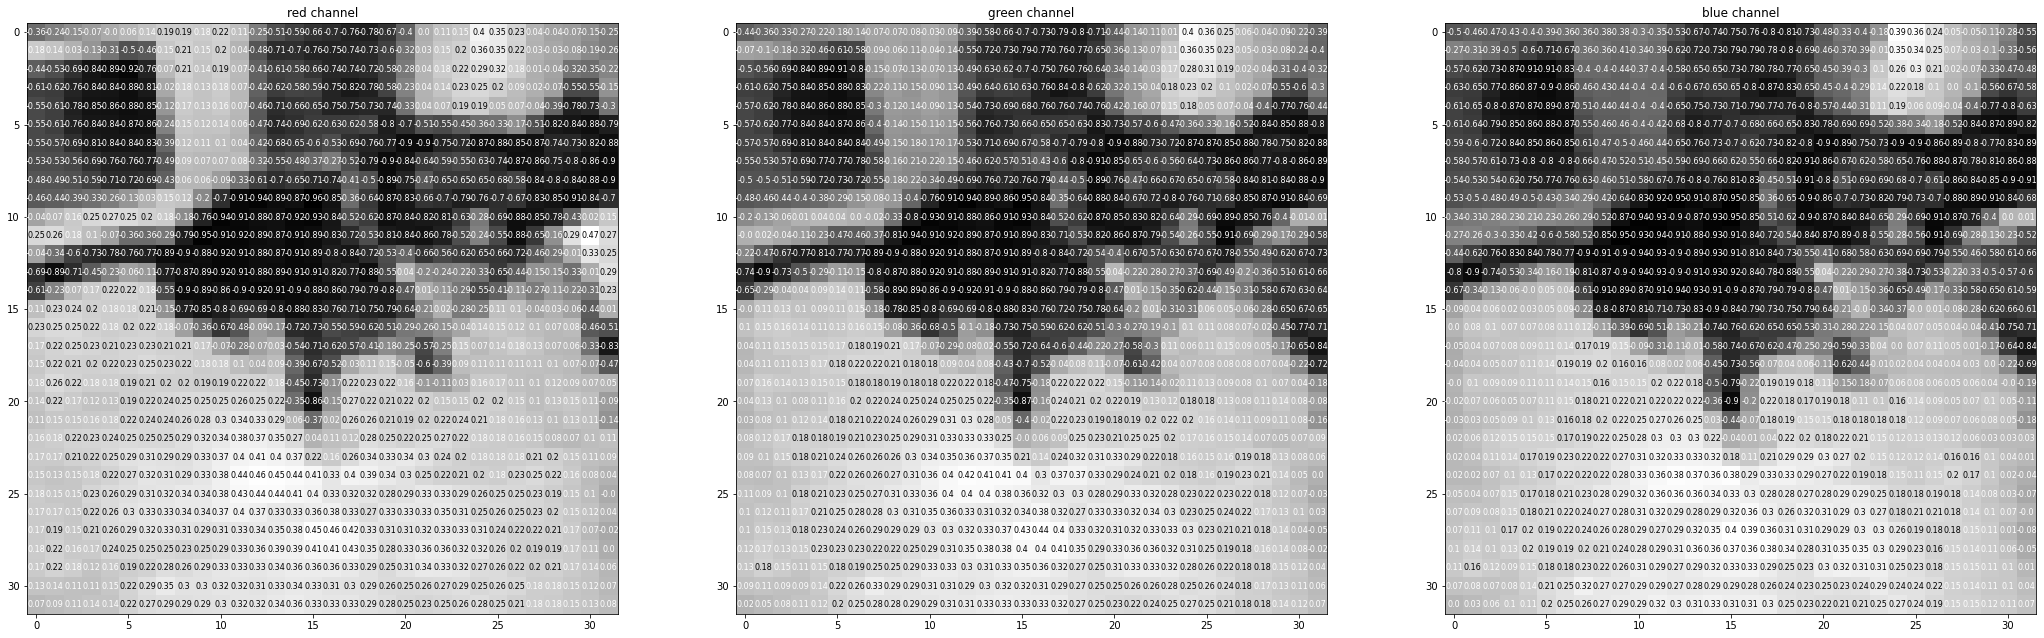

In [21]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

In [73]:
import torch.nn as nn
import torch.nn.functional as F

# defining the architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # convolutional layer
        # input = (32x32x3)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # input = (16x16x16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # input = (8x8x32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # conv output = 8*8*64
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*4*4, 500)
        self.fc2 = nn.Linear(500,10)
        
        self.dropout = nn.Dropout(0.25)
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # flatten the image
        x = x.view(-1, 64*4*4)
        x = self.dropout(x)
        x = self.dropout(F.relu(self.fc1(x)))
        
        x = self.fc2(x)
        
        return x
    
    
    
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [74]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [75]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

for e in range(n_epochs):
    
    train_loss = 0.0
    valid_loss = 0.0
    
    # go to train mode
    model.train()
    for images, labels in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        # clear the gradients of the optimizers
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*images.size(0)
        
    ## validation loop
    model.eval()
    for images, labels in valid_loader:
        
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        output = model(images)
        loss = criterion(output, labels)
        
        valid_loss += loss.item()*images.size(0)
        
    # calculate the averaghe loss over the whole epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e, train_loss, valid_loss))
    
    # save the model if the validation loss is less than current valid loss
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar_practice.pt')
        valid_loss_min = valid_loss
        
        
        

Epoch: 0 	Training Loss: 2.126558 	Validation Loss: 1.803835
Validation loss decreased (inf --> 1.803835).  Saving model ...
Epoch: 1 	Training Loss: 1.645161 	Validation Loss: 1.476420
Validation loss decreased (1.803835 --> 1.476420).  Saving model ...
Epoch: 2 	Training Loss: 1.452092 	Validation Loss: 1.349832
Validation loss decreased (1.476420 --> 1.349832).  Saving model ...
Epoch: 3 	Training Loss: 1.335801 	Validation Loss: 1.253119
Validation loss decreased (1.349832 --> 1.253119).  Saving model ...
Epoch: 4 	Training Loss: 1.244038 	Validation Loss: 1.162909
Validation loss decreased (1.253119 --> 1.162909).  Saving model ...
Epoch: 5 	Training Loss: 1.162855 	Validation Loss: 1.097616
Validation loss decreased (1.162909 --> 1.097616).  Saving model ...
Epoch: 6 	Training Loss: 1.099325 	Validation Loss: 1.046014
Validation loss decreased (1.097616 --> 1.046014).  Saving model ...
Epoch: 7 	Training Loss: 1.042508 	Validation Loss: 1.012093
Validation loss decreased (1.04601

In [76]:
# reload the model for testing purpose
model.load_state_dict(torch.load('model_cifar_practice.pt'))

<All keys matched successfully>

In [77]:
test_loss = 0.0
class_correct = [0. for i in range(10)]
class_total = [0. for i in range(10)]

model.eval()
for images, labels in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        images, labels = images.cuda(), labels.cuda()
            
    output = model.forward(images)
    loss = criterion(output, labels)
    test_loss += loss.item() * images.size(0)
    top_ps, top_class = output.topk(1, dim=1)
    
    # correct tensor is the bianry tensor that shows if we predicted the values correctly or not
    correct_tensor = top_class == labels.view(*top_class.shape)
    # here correct is the binary tensor that indicates whether we got it correct or not
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
    # average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
        

Test Loss: 0.718178

Test Accuracy of airplane: 82% (820/1000)
Test Accuracy of automobile: 87% (873/1000)
Test Accuracy of  bird: 67% (677/1000)
Test Accuracy of   cat: 65% (650/1000)
Test Accuracy of  deer: 70% (703/1000)
Test Accuracy of   dog: 61% (618/1000)
Test Accuracy of  frog: 81% (818/1000)
Test Accuracy of horse: 82% (824/1000)
Test Accuracy of  ship: 85% (851/1000)
Test Accuracy of truck: 82% (821/1000)

Test Accuracy (Overall): 76% (7655/10000)
